# improting libraries

In [217]:
import pandas as pd
import numpy as np 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# importing data set 

In [218]:
raw_dataset = pd.read_csv('DATA.csv')
#raw_dataset

In [219]:
raw_dataset = raw_dataset.drop(raw_dataset[raw_dataset['IVIG '] == 'NOT'].index )
raw_dataset = raw_dataset.drop(raw_dataset[raw_dataset['IVIG '] == '?'].index )

In [220]:
raw_dataset.head()

,id,sex,age,conjunctivitis,rash,IVIG,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na,duration of fever
1,390,M,0,NEGATIVE,POSITIVE,POSITIVE,7.5,15,677,38,0.6,12.3,34,36,?,3.7,81,77,136,12
2,389,F,2,POSITIVE,POSITIVE,NEGATIVE,9.4,13.3,377,48,0.96,7.5,28,43,?,3.9,6,?,137,7
3,388,M,5,NEGATIVE,POSITIVE,POSITIVE,11.5,4,227,76.4,3.5,10.4,?,?,?,?,1,25,135,4
4,387,F,10,POSITIVE,POSITIVE,POSITIVE,10.3,14.1,463,79,3.9,23.1,53,156,?,4,13,48,135,5
5,385,F,3,POSITIVE,NEGATIVE,POSITIVE,11.5,11.2,765,46.7,0.9,16.1,20,14,?,4.6,12,58,138,7


دیتای نامشخص در دیتاست اصلی با علامت سوال مشخص شده بود در اینجا ما در ابتدا این علامت های سوال را با نال نامپای عوض کردیم

سپس نوشته های مثبت و منفی را به یک و صفر تغییر دادم

In [221]:
raw_dataset = raw_dataset.replace(['?'], np.nan)
raw_dataset['IVIG ']=raw_dataset['IVIG '].replace('POSITIVE',1)
raw_dataset['IVIG ']=raw_dataset['IVIG '].replace('NEGATIVE',0)

In [222]:
raw_dataset.head()

,id,sex,age,conjunctivitis,rash,IVIG,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na,duration of fever
1,390,M,0,NEGATIVE,POSITIVE,1,7.5,15,677,38,0.6,12.3,34,36,NaN,3.7,81,77,136,12
2,389,F,2,POSITIVE,POSITIVE,0,9.4,13.3,377,48,0.96,7.5,28,43,NaN,3.9,6,NaN,137,7
3,388,M,5,NEGATIVE,POSITIVE,1,11.5,4,227,76.4,3.5,10.4,NaN,NaN,NaN,NaN,1,25,135,4
4,387,F,10,POSITIVE,POSITIVE,1,10.3,14.1,463,79,3.9,23.1,53,156,NaN,4,13,48,135,5
5,385,F,3,POSITIVE,NEGATIVE,1,11.5,11.2,765,46.7,0.9,16.1,20,14,NaN,4.6,12,58,138,7


# handling missing values 

as mentioned in report paper this dataset has a lot of missing values.
we generally mentioned that deletion is not an option here since the record is not huge 
but there is one exception and thats missing values for our outcome attribute 
in this column we delete any row with missing values 


## handlin missing values in IVIG column
since this part was the target of classificaiton we omited rows with missing value in this columns

In [223]:
pos_dataset= raw_dataset.copy()
pos_dataset = pos_dataset.drop(pos_dataset[pos_dataset['IVIG '] == 0].index )
neg_dataset= raw_dataset.copy()
neg_dataset = neg_dataset.drop(neg_dataset[neg_dataset['IVIG '] == 1].index )

## handling missing values with interpolation 

first we need to find columns which have null value as input

In [224]:
nulls = []
col = pos_dataset.columns
for i in col:
    if sum(pos_dataset[i].isnull()) > 0:
        nulls.append(i)
nulls

['Hb',
 'wbc',
 'plt',
 'neutrophil',
 'NLR',
 'PLR',
 'AST',
 'ALT',
 'Bili T',
 'alb',
 'CRP',
 'ESR',
 'Na']

first we interpolated with polynomial method to get a better result 
but even with both direction polynomial interpolation there was null value in the begining or ending of some colunms especially bili T
so for filling those blanks i added a for loop to interpolate those remained null values with linear method 

In [225]:
neg_dataset_inter= neg_dataset
pos_dataset_inter= pos_dataset
for i in nulls : 
    neg_dataset_inter[i] = pd.to_numeric(neg_dataset_inter[i], errors='coerce')
    pos_dataset_inter[i] = pd.to_numeric(pos_dataset_inter[i], errors='coerce')
    
neg_dataset_inter[nulls] = neg_dataset_inter[nulls].interpolate('polynomial',order= 3,limit_direction='both')
pos_dataset_inter[nulls] = pos_dataset_inter[nulls].interpolate('polynomial',order= 3,limit_direction='both')

for i in nulls :
    neg_dataset_inter[i] = neg_dataset[i].interpolate('linear',limit_direction='both')
    pos_dataset_inter[i] = pos_dataset_inter[i].interpolate('linear',limit_direction='both')
    
pos_dataset_inter


,id,sex,age,conjunctivitis,rash,IVIG,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na,duration of fever
1,390,M,0,NEGATIVE,POSITIVE,1,7.5,15.0,677.0,38.000000,0.600000,12.300000,34.000000,36.000000,0.240000,3.70000,81.0,77.000000,136.000000,12
3,388,M,5,NEGATIVE,POSITIVE,1,11.5,4.0,227.0,76.400000,3.500000,10.400000,83.821437,284.466314,0.240000,2.31415,1.0,25.000000,135.000000,4
4,387,F,10,POSITIVE,POSITIVE,1,10.3,14.1,463.0,79.000000,3.900000,23.100000,53.000000,156.000000,0.240000,4.00000,13.0,48.000000,135.000000,5
5,385,F,3,POSITIVE,NEGATIVE,1,11.5,11.2,765.0,46.700000,0.900000,16.100000,20.000000,14.000000,0.240000,4.60000,12.0,58.000000,138.000000,7
6,384,M,0,NEGATIVE,NEGATIVE,1,8.9,9.3,953.0,25.100000,0.400000,15.300000,35.000000,26.000000,0.240000,3.40000,40.0,38.000000,133.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,105,F,0,NEGATIVE,NEGATIVE,1,8.3,11.9,621.0,22.900000,0.300000,8.600000,58.000000,76.000000,1.237873,3.90000,60.0,42.000000,131.000000,30
277,111,F,1,POSITIVE,POSITIVE,1,9.3,7.9,456.0,54.033401,1.189626,10.586535,31.000000,17.000000,0.893572,6.20000,64.0,17.745673,115.787369,4
278,122,M,4,NEGATIVE,NEGATIVE,1,12.5,8.1,588.0,60.000000,1.500000,14.700000,37.000000,19.000000,0.676568,4.70000,4.0,60.000000,131.000000,3
279,140,F,0,NEGATIVE,POSITIVE,1,9.4,27.9,683.0,63.000000,1.900000,21.300000,87.000000,61.000000,0.400000,3.80000,68.0,120.000000,131.000000,14


In [226]:
neg_dataset_inter

,id,sex,age,conjunctivitis,rash,IVIG,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na,duration of fever
2,389,F,2,POSITIVE,POSITIVE,0,9.4,13.3,377,48.000000,0.960000,7.500000,28.000000,43.000000,0.400000,3.900000,6.00000,55.000000,137.000000,7
27,362,M,5,POSITIVE,POSITIVE,0,10.7,8.6,319,70.000000,3.500000,15.900000,27.000000,86.000000,0.400000,4.100000,0.00000,55.000000,137.000000,5
28,361,M,2,POSITIVE,POSITIVE,0,13.8,13.9,312,75.000000,3.200000,13.500000,322.085244,319.223306,0.400000,3.947182,4.00000,25.000000,137.000000,7
29,360,M,0,POSITIVE,POSITIVE,0,10.0,11.8,597,18.000000,0.200000,7.300000,464.000000,420.000000,0.745951,3.800000,1.00000,73.000000,134.000000,10
33,356,M,1,POSITIVE,POSITIVE,0,7.7,16.4,537,70.000000,3.100000,24.400000,65.000000,30.000000,1.572634,3.300000,0.00000,100.000000,135.000000,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,92,M,3,POSITIVE,POSITIVE,0,7.6,16.6,383,58.000000,1.400000,9.800000,17.000000,10.000000,3.457406,3.500000,62.00000,-1.063578,127.000000,5
270,95,F,2,NEGATIVE,POSITIVE,0,9.9,7.9,302,37.000000,0.600000,5.200000,32.773234,17.694693,2.592319,3.313979,41.85501,-7.117343,130.981823,14
273,103,F,3,POSITIVE,NEGATIVE,0,11.7,14.9,367,40.109164,0.895529,9.231637,39.000000,17.000000,1.196966,3.292704,47.00000,50.000000,135.000000,20
275,106,F,6,POSITIVE,NEGATIVE,0,10.2,10.2,427,54.200000,1.400000,11.400000,24.000000,13.000000,0.200000,3.800000,60.00000,95.000000,132.000000,10


In [227]:
dataset_inter= pd.concat([pos_dataset_inter,neg_dataset_inter], ignore_index = True)
dataset_inter=dataset_inter.sample(frac = 1)

## handling missing values with KNN


In [228]:
pos_dataset= raw_dataset.copy()
pos_dataset = pos_dataset.drop(pos_dataset[pos_dataset['IVIG '] == 0].index )
neg_dataset= raw_dataset.copy()
neg_dataset = neg_dataset.drop(neg_dataset[neg_dataset['IVIG '] == 1].index )

In [229]:
from sklearn.impute import KNNImputer
neg_dataset_knn= neg_dataset

imputer = KNNImputer(n_neighbors=5)
neg_dataset_knn = pd.DataFrame(imputer.fit_transform(neg_dataset[nulls]), columns=nulls)
neg_dataset_knn

,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na
0,9.4,13.3,377.0,48.0,0.960,7.50,28.0,43.0,0.380,3.90,6.0,74.4,137.0
1,10.7,8.6,319.0,70.0,3.500,15.90,27.0,86.0,0.380,4.10,0.0,55.0,137.0
2,13.8,13.9,312.0,75.0,3.200,13.50,134.0,149.4,0.400,3.82,4.0,25.0,137.0
3,10.0,11.8,597.0,18.0,0.200,7.30,464.0,420.0,0.726,3.80,1.0,73.0,134.0
4,7.7,16.4,537.0,70.0,3.100,24.40,65.0,30.0,0.496,3.30,0.0,100.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,7.6,16.6,383.0,58.0,1.400,9.80,17.0,10.0,0.380,3.50,62.0,82.4,127.0
71,9.9,7.9,302.0,37.0,0.600,5.20,249.8,139.6,0.606,4.16,21.0,46.0,135.2
72,11.7,14.9,367.0,59.4,4.112,21.04,39.0,17.0,0.380,3.86,47.0,50.0,135.0
73,10.2,10.2,427.0,54.2,1.400,11.40,24.0,13.0,0.200,3.80,60.0,95.0,132.0


In [230]:
colset = ['id', 'sex', 'age', 'conjunctivitis', 'rash', 'IVIG ','duration of fever']


In [231]:
neg_knn = pd.merge(neg_dataset[colset],neg_dataset_knn,left_index=True,right_index=True)
neg_knn

,id,sex,age,conjunctivitis,rash,IVIG,duration of fever,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na
2,389,F,2,POSITIVE,POSITIVE,0,7,13.8,13.9,312.0,75.0,3.2,13.5,134.0,149.4,0.400,3.82,4.0,25.0,137.0
27,362,M,5,POSITIVE,POSITIVE,0,5,10.6,24.7,1220.0,75.0,3.4,55.4,63.0,40.0,1.536,4.80,43.0,62.0,133.0
28,361,M,2,POSITIVE,POSITIVE,0,7,9.2,9.9,587.0,75.0,4.4,34.5,24.0,27.0,0.496,3.50,60.0,88.0,135.0
29,360,M,0,POSITIVE,POSITIVE,0,10,6.8,13.1,346.0,72.0,3.2,20.3,50.0,28.0,0.320,3.30,57.0,120.0,136.0
33,356,M,1,POSITIVE,POSITIVE,0,40,11.8,19.0,400.0,90.0,15.0,66.6,29.0,15.0,0.600,4.30,56.0,52.0,135.0
35,351,F,2,NEGATIVE,POSITIVE,0,9,10.3,7.4,922.0,55.0,1.3,23.0,38.0,14.0,1.536,4.30,30.0,93.0,135.0
39,347,F,0,NEGATIVE,POSITIVE,0,7,8.5,14.3,816.0,77.0,3.8,40.8,33.0,25.0,1.596,3.90,49.0,95.0,132.0
47,339,M,4,NEGATIVE,POSITIVE,0,12,11.0,14.2,294.0,76.0,5.0,19.6,24.0,18.0,0.380,4.10,2.0,40.0,136.0
48,338,F,3,POSITIVE,POSITIVE,0,8,10.3,11.4,284.0,34.0,0.7,6.0,20.0,16.0,0.380,3.90,32.6,62.0,130.0
50,336,M,10,NEGATIVE,POSITIVE,0,7,12.1,14.5,389.0,68.0,2.7,15.5,16.0,10.0,0.420,3.70,56.0,65.0,132.0


In [232]:
pos_dataset_knn = pd.DataFrame(imputer.fit_transform(pos_dataset[nulls]), columns=nulls)
pos_dataset_knn

,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na
0,7.5,15.0,677.0,38.00,0.600,12.300,34.0,36.0,0.698,3.70,81.0,77.0,136.0
1,11.5,4.0,227.0,76.40,3.500,10.400,56.4,49.8,0.554,3.58,1.0,25.0,135.0
2,10.3,14.1,463.0,79.00,3.900,23.100,53.0,156.0,0.920,4.00,13.0,48.0,135.0
3,11.5,11.2,765.0,46.70,0.900,16.100,20.0,14.0,0.544,4.60,12.0,58.0,138.0
4,8.9,9.3,953.0,25.10,0.400,15.300,35.0,26.0,0.400,3.40,40.0,38.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,8.3,11.9,621.0,22.90,0.300,8.600,58.0,76.0,0.400,3.90,60.0,42.0,131.0
187,9.3,7.9,456.0,56.04,2.300,16.080,31.0,17.0,0.660,6.20,64.0,62.4,134.4
188,12.5,8.1,588.0,60.00,1.500,14.700,37.0,19.0,0.400,4.70,4.0,60.0,131.0
189,9.4,27.9,683.0,63.00,1.900,21.300,87.0,61.0,0.400,3.80,68.0,120.0,135.2


In [233]:
pos_knn = pd.merge(pos_dataset[colset],pos_dataset_knn,left_index=True,right_index=True)
pos_knn

,id,sex,age,conjunctivitis,rash,IVIG,duration of fever,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na
1,390,M,0,NEGATIVE,POSITIVE,1,12,11.5,4.00,227.0,76.40,3.5,10.40,56.4,49.8,0.554,3.58,1.0,25.0,135.0
3,388,M,5,NEGATIVE,POSITIVE,1,4,11.5,11.20,765.0,46.70,0.9,16.10,20.0,14.0,0.544,4.60,12.0,58.0,138.0
4,387,F,10,POSITIVE,POSITIVE,1,5,8.9,9.30,953.0,25.10,0.4,15.30,35.0,26.0,0.400,3.40,40.0,38.0,133.0
5,385,F,3,POSITIVE,NEGATIVE,1,7,11.1,7.40,257.0,80.00,8.0,25.70,145.0,306.0,1.836,3.40,37.0,12.0,132.0
6,384,M,0,NEGATIVE,NEGATIVE,1,5,10.1,21.45,382.0,82.00,5.8,27.20,35.0,13.0,0.440,3.60,94.0,33.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,157,F,1,NEGATIVE,POSITIVE,1,6,10.7,5.20,167.0,64.00,2.0,5.30,40.0,11.0,0.500,3.88,1.0,20.0,138.0
186,154,F,4,POSITIVE,POSITIVE,1,6,8.3,11.90,621.0,22.90,0.3,8.60,58.0,76.0,0.400,3.90,60.0,42.0,131.0
187,153,M,2,POSITIVE,NEGATIVE,1,12,9.3,7.90,456.0,56.04,2.3,16.08,31.0,17.0,0.660,6.20,64.0,62.4,134.4
188,152,M,5,POSITIVE,POSITIVE,1,10,12.5,8.10,588.0,60.00,1.5,14.70,37.0,19.0,0.400,4.70,4.0,60.0,131.0


In [234]:
dataset_knn= pd.concat([pos_knn,neg_knn], ignore_index = True)
dataset_knn=dataset_knn.sample(frac = 1)
dataset_knn

,id,sex,age,conjunctivitis,rash,IVIG,duration of fever,Hb,wbc,plt,neutrophil,NLR,PLR,AST,ALT,Bili T,alb,CRP,ESR,Na
46,308,M,0,NEGATIVE,NEGATIVE,1,3,13.1,19.4,455.0,75.00,3.70,22.70,30.0,31.0,0.400,4.20,92.0,74.0,127.0
122,362,M,5,POSITIVE,POSITIVE,0,5,10.6,24.7,1220.0,75.00,3.40,55.40,63.0,40.0,1.536,4.80,43.0,62.0,133.0
77,230,M,1,POSITIVE,NEGATIVE,1,10,10.3,21.8,505.0,57.10,1.40,13.11,37.0,26.0,0.360,4.20,65.0,48.0,133.0
87,206,M,5,POSITIVE,POSITIVE,1,4,9.0,14.4,560.0,78.20,3.91,28.00,22.0,10.0,0.360,4.20,116.0,75.0,134.0
107,170,M,6,NEGATIVE,POSITIVE,1,9,11.4,6.9,602.0,41.00,0.70,10.70,33.0,12.0,0.400,4.16,6.0,90.0,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,318,M,3,NEGATIVE,POSITIVE,0,5,10.8,18.2,290.0,88.00,7.30,24.10,175.0,139.0,0.406,3.60,138.0,46.4,132.0
109,167,F,0,POSITIVE,POSITIVE,1,8,10.8,14.4,988.0,42.24,0.90,19.10,25.0,15.0,0.400,4.10,47.0,58.6,134.0
73,238,M,2,POSITIVE,POSITIVE,1,8,8.8,12.8,546.0,65.40,2.30,19.80,37.0,14.0,0.340,3.80,29.0,48.0,136.2
111,162,M,6,POSITIVE,NEGATIVE,1,14,7.4,18.1,722.0,32.60,0.50,12.00,40.0,13.0,0.600,4.26,3.0,48.0,128.0


# models

# cross validation

In [235]:
# K-Fold Cross-Validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
def cross_validation(model, _X, _y, _cv=5):
     
    _scoring = ['accuracy', 'precision', 'recall', 'f1']
    results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)

    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
   
    sns.heatmap(conf_mat,
                annot=True,
                fmt='g',
                xticklabels=['non_resistant', 'resistant'],
                yticklabels=['non_resistant', 'resistant'])
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.show()


      
    return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

# functions for plotting results

In [236]:
# Grouped Bar Chart for both training and validation data
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [237]:
def allplot(model_name,model_result):
    
# Plot Accuracy Result
    model_name = model_name
    plot_result(model_name,
                "Accuracy",
                "Accuracy scores in 5 Folds",
                model_result["Training Accuracy scores"],
                model_result["Validation Accuracy scores"])
    # Plot Precision Result
    plot_result(model_name,
                "Precision",
                "Precision scores in 5 Folds",
                model_result["Training Precision scores"],
                model_result["Validation Precision scores"])
    # Plot Recall Result
    plot_result(model_name,
                "Recall",
                "Recall scores in 5 Folds",
                decision_tree_result["Training Recall scores"],
                decision_tree_result["Validation Recall scores"])
    
    
    
    # Plot F1-Score Result
    plot_result(model_name,
                "F1",
                "F1 Scores in 5 Folds",
                decision_tree_result["Training F1 scores"],
                decision_tree_result["Validation F1 scores"])

### preparing data

In [238]:
# with knn data
one_hot_encoded_data = pd.get_dummies(dataset_knn, columns = ['sex', 'conjunctivitis','rash'])
col= list(one_hot_encoded_data.columns)
col.remove('IVIG ')
col.remove('id')
features = col
X = one_hot_encoded_data[features]
y = one_hot_encoded_data['IVIG ']

# with interpolated data
one_hot_encoded_data = pd.get_dummies(dataset_inter, columns = ['sex', 'conjunctivitis','rash'])
X_inter = one_hot_encoded_data[features]
y_inter = one_hot_encoded_data['IVIG ']

# decision tree

### decision tree 

#### with knn data

In [248]:
dtree = DecisionTreeClassifier(min_samples_split= 20)
dtree = dtree.fit(X, y)

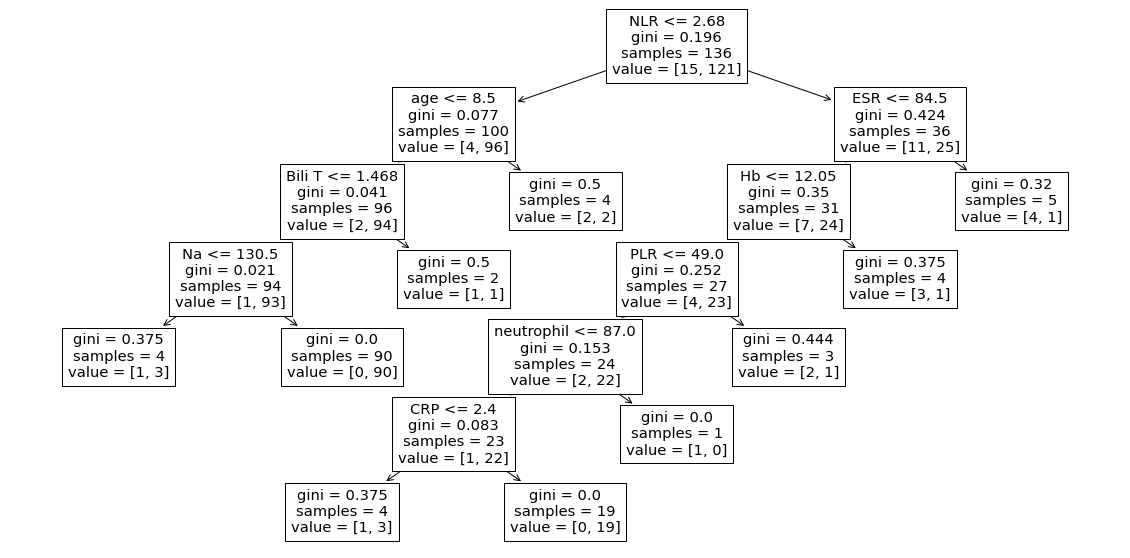

In [249]:
plt.figure(figsize=(20,10))  # set plot size (denoted in inches)
tree.plot_tree(dtree, feature_names=features)
plt.show()

### decision tree results and confusion matrix 

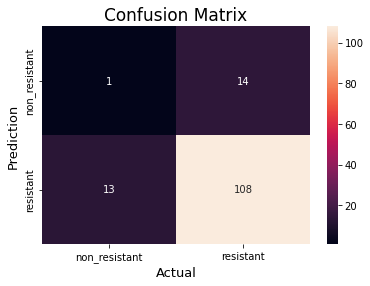

{'Training Accuracy scores': array([0.89814815, 0.89908257, 0.91743119, 0.9266055 , 0.90825688]), 'Mean Training Accuracy': 90.99048589874276, 'Training Precision scores': array([0.94736842, 0.98863636, 0.93137255, 0.92380952, 0.9223301 ]), 'Mean Training Precision': 0.9427033909211012, 'Training Recall scores': array([0.9375    , 0.89690722, 0.97938144, 1.        , 0.97938144]), 'Mean Training Recall': 0.9586340206185566, 'Training F1 scores': array([0.94240838, 0.94054054, 0.95477387, 0.96039604, 0.95      ]), 'Mean Training F1 Score': 0.9496237652909171, 'Validation Accuracy scores': array([0.75      , 0.74074074, 0.85185185, 0.81481481, 0.85185185]), 'Mean Validation Accuracy': 80.18518518518519, 'Validation Precision scores': array([0.875     , 0.9047619 , 0.88461538, 0.88      , 0.88461538]), 'Mean Validation Precision': 0.8857985347985349, 'Validation Recall scores': array([0.84      , 0.79166667, 0.95833333, 0.91666667, 0.95833333]), 'Mean Validation Recall': 0.893, 'Validation

In [250]:
decision_tree_result = cross_validation(dtree, X, y, 5)
print(decision_tree_result)


### accuracy ,  precision , recall , F1 

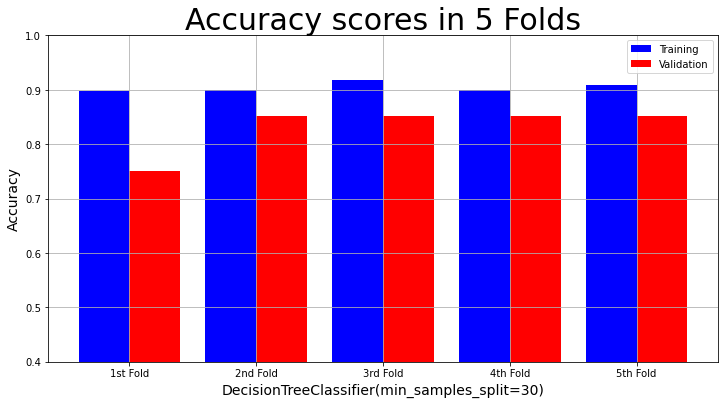

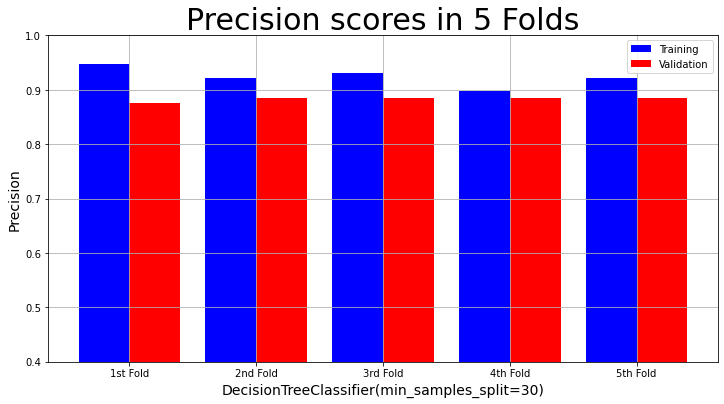

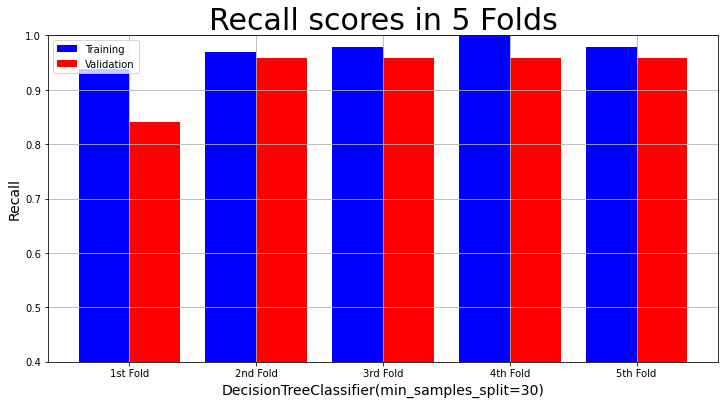

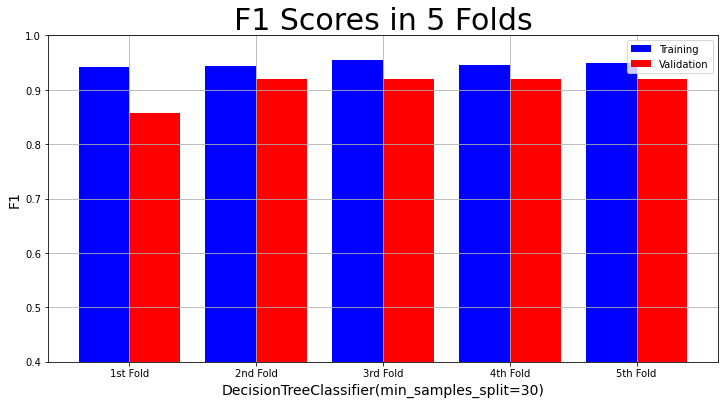

In [242]:
allplot(dtree,decision_tree_result)

as we can see with default setting of decision tree in sklearn the validation scores for our dataset is not high 
by changing parameters i have made a better model with higher score

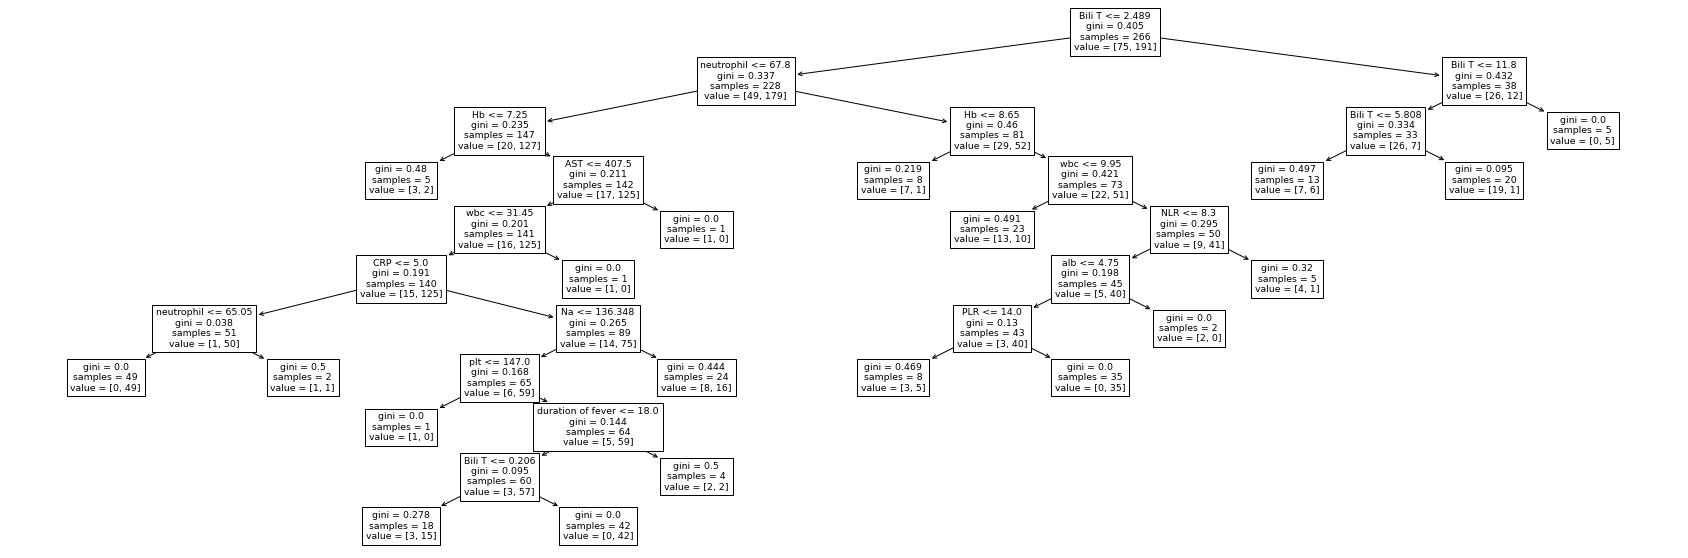

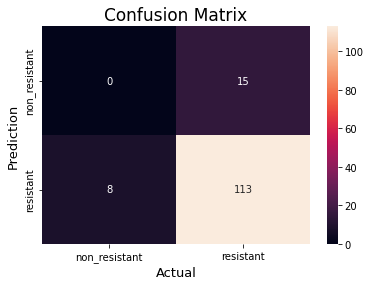

{'Training Accuracy scores': array([0.89814815, 0.89908257, 0.91743119, 0.89908257, 0.90825688]), 'Mean Training Accuracy': 90.44002718314644, 'Training Precision scores': array([0.94736842, 0.92156863, 0.93137255, 0.89814815, 0.9223301 ]), 'Mean Training Precision': 0.9241575685517492, 'Training Recall scores': array([0.9375    , 0.96907216, 0.97938144, 1.        , 0.97938144]), 'Mean Training Recall': 0.9730670103092784, 'Training F1 scores': array([0.94240838, 0.94472362, 0.95477387, 0.94634146, 0.95      ]), 'Mean Training F1 Score': 0.9476494655630342, 'Validation Accuracy scores': array([0.75      , 0.85185185, 0.85185185, 0.85185185, 0.85185185]), 'Mean Validation Accuracy': 83.14814814814815, 'Validation Precision scores': array([0.875     , 0.88461538, 0.88461538, 0.88461538, 0.88461538]), 'Mean Validation Precision': 0.8826923076923077, 'Validation Recall scores': array([0.84      , 0.95833333, 0.95833333, 0.95833333, 0.95833333]), 'Mean Validation Recall': 0.9346666666666668

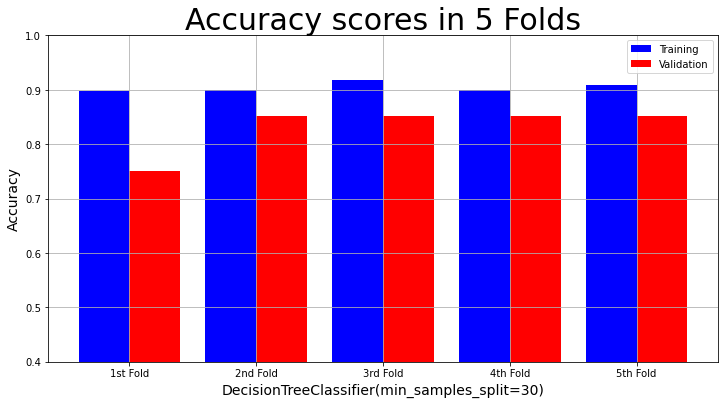

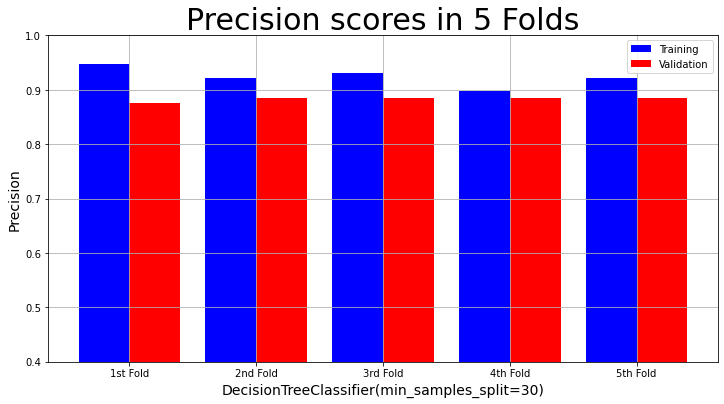

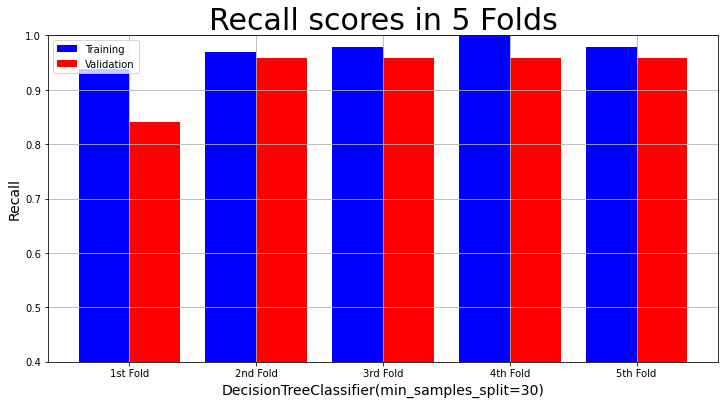

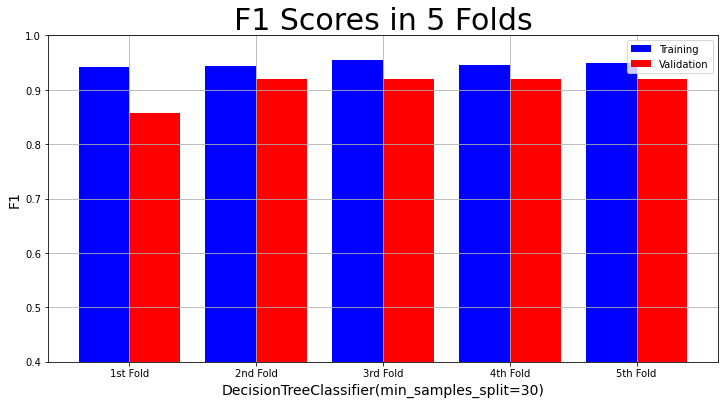

In [243]:
dtree2 = DecisionTreeClassifier(criterion="gini",
                                               min_samples_split=20,
                                               random_state=0)
dtree2 = dtree.fit(X_inter, y_inter)
plt.figure(figsize=(30,10)) 

tree.plot_tree(dtree2, feature_names=features)
plt.show()
decision_tree_result2 = cross_validation(dtree2, X, y, 5)
print(decision_tree_result2)
allplot(dtree,decision_tree_result2)

# SVM


training svm with knn dataset 

In [244]:
from sklearn import svm

#Create a svm Classifier
svmclf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svmclf.fit(X, y)


SVC(kernel='linear')

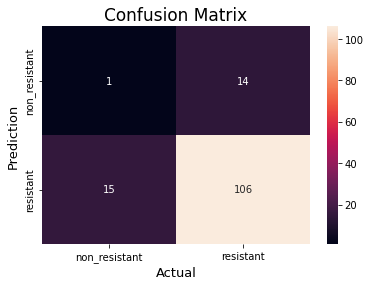

{'Training Accuracy scores': array([0.94444444, 0.91743119, 0.94495413, 0.9266055 , 0.90825688]), 'Mean Training Accuracy': 92.83384301732924, 'Training Precision scores': array([0.95      , 0.93137255, 0.95049505, 0.93203883, 0.9223301 ]), 'Mean Training Precision': 0.9372473061126787, 'Training Recall scores': array([0.98958333, 0.97938144, 0.98969072, 0.98969072, 0.97938144]), 'Mean Training Recall': 0.985545532646048, 'Training F1 scores': array([0.96938776, 0.95477387, 0.96969697, 0.96      , 0.95      ]), 'Mean Training F1 Score': 0.9607717188291488, 'Validation Accuracy scores': array([0.60714286, 0.88888889, 0.81481481, 0.77777778, 0.85185185]), 'Mean Validation Accuracy': 78.80952380952382, 'Validation Precision scores': array([0.85      , 0.88888889, 0.88      , 0.875     , 0.91666667]), 'Mean Validation Precision': 0.8821111111111112, 'Validation Recall scores': array([0.68      , 1.        , 0.91666667, 0.875     , 0.91666667]), 'Mean Validation Recall': 0.8776666666666667,

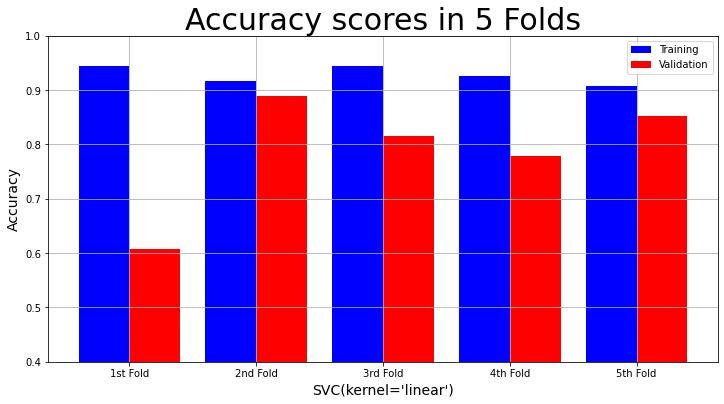

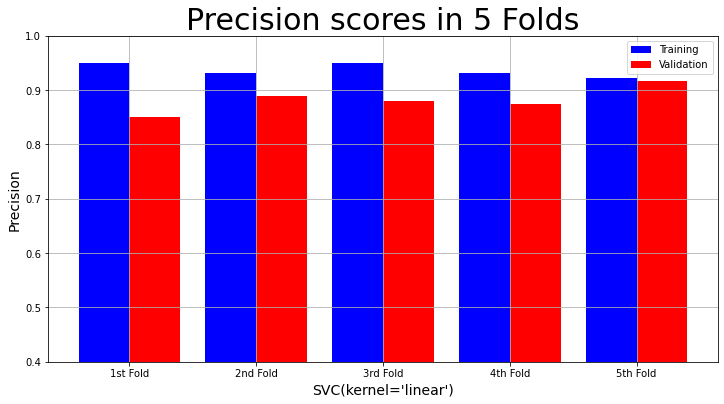

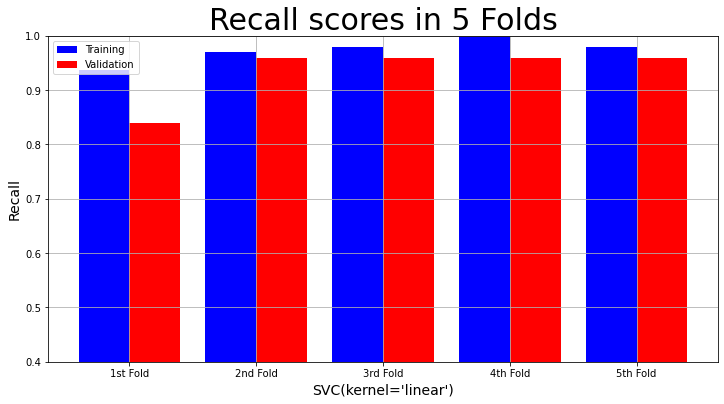

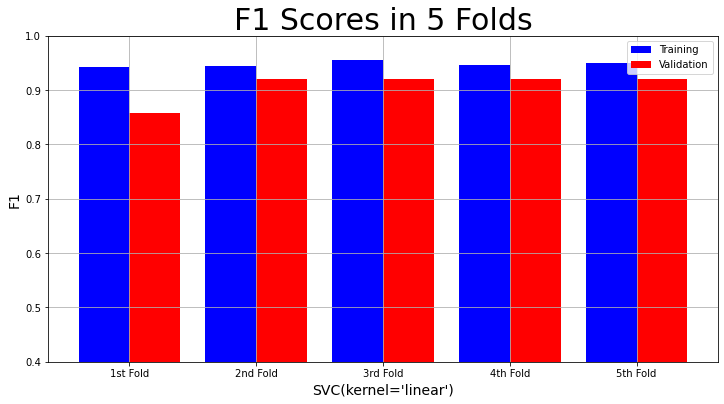

In [245]:
svm_result = cross_validation(svmclf, X, y, 5)
print(svm_result)
allplot(svmclf,svm_result)

### another svm classifier with rbf kernel 

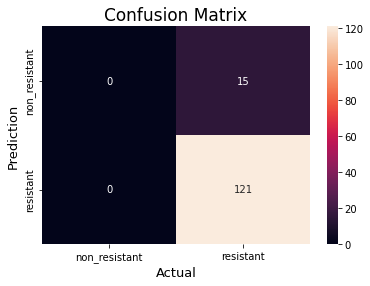

{'Training Accuracy scores': array([0.88888889, 0.88990826, 0.88990826, 0.88990826, 0.88990826]), 'Mean Training Accuracy': 88.97043832823648, 'Training Precision scores': array([0.88888889, 0.88990826, 0.88990826, 0.88990826, 0.88990826]), 'Mean Training Precision': 0.8897043832823648, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([0.94117647, 0.94174757, 0.94174757, 0.94174757, 0.94174757]), 'Mean Training F1 Score': 0.9416333523700743, 'Validation Accuracy scores': array([0.89285714, 0.88888889, 0.88888889, 0.88888889, 0.88888889]), 'Mean Validation Accuracy': 88.96825396825395, 'Validation Precision scores': array([0.89285714, 0.88888889, 0.88888889, 0.88888889, 0.88888889]), 'Mean Validation Precision': 0.8896825396825395, 'Validation Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Validation Recall': 1.0, 'Validation F1 scores': array([0.94339623, 0.94117647, 0.94117647, 0.94117647, 0.94117647]), 'Mean Validatio

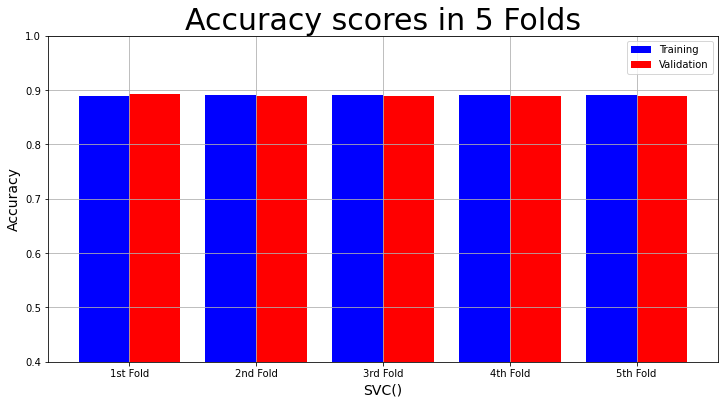

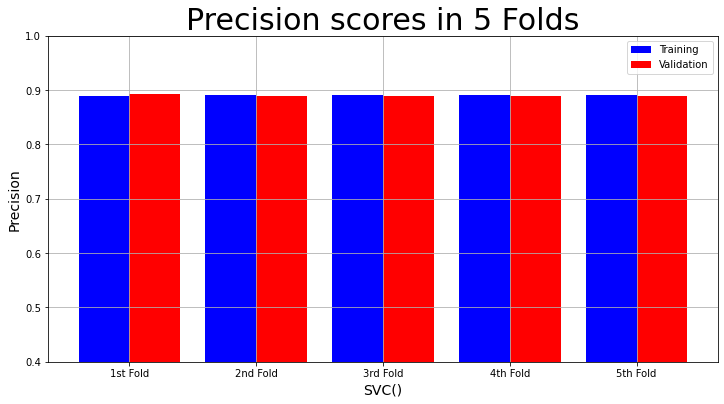

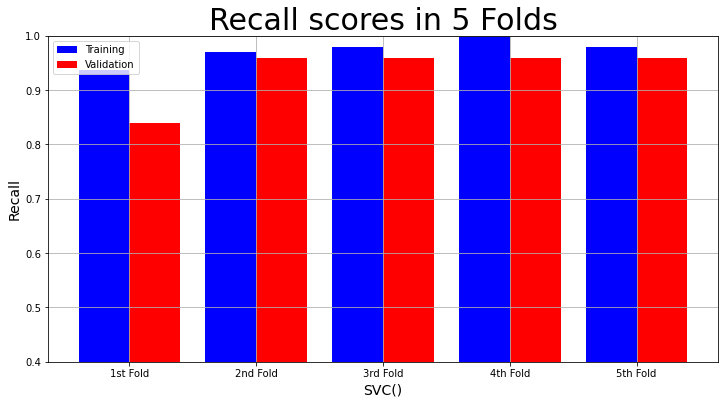

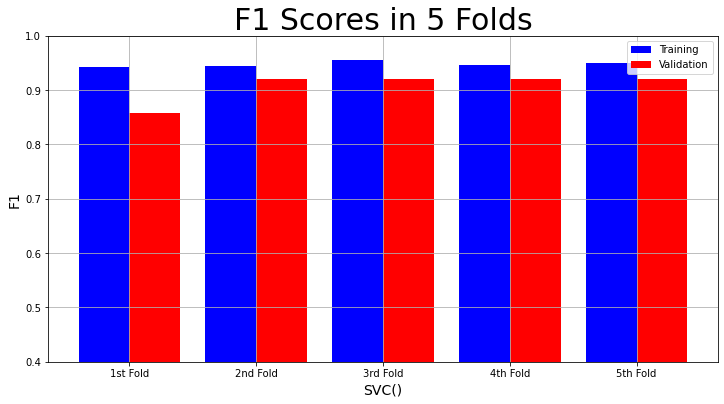

In [246]:
#Create a svm Classifier
svmclf2 = svm.SVC(kernel='rbf') # Linear Kernel
#Train the model using the training sets
svmclf2.fit(X, y)

svm_result2 = cross_validation(svmclf2, X, y, 5)
print(svm_result2)
allplot(svmclf2,svm_result2)

### SVM classifiers with interpolated dataset 

#### linear kernel

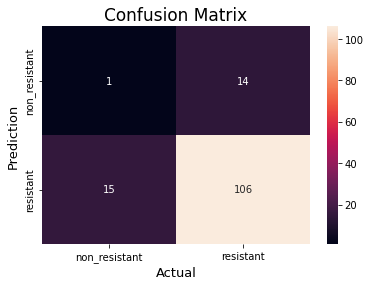

{'Training Accuracy scores': array([0.8254717 , 0.78873239, 0.81220657, 0.81220657, 0.82629108]), 'Mean Training Accuracy': 81.29816635663035, 'Training Precision scores': array([0.83625731, 0.79347826, 0.81920904, 0.8265896 , 0.84117647]), 'Mean Training Precision': 0.8233421352646131, 'Training Recall scores': array([0.94078947, 0.95424837, 0.94771242, 0.93464052, 0.93464052]), 'Mean Training Recall': 0.942406260749914, 'Training F1 scores': array([0.88544892, 0.86646884, 0.87878788, 0.87730061, 0.88544892]), 'Mean Training F1 Score': 0.8786910335664239, 'Validation Accuracy scores': array([0.7962963 , 0.71698113, 0.83018868, 0.79245283, 0.77358491]), 'Mean Validation Accuracy': 78.19007686932216, 'Validation Precision scores': array([0.83333333, 0.75555556, 0.82222222, 0.8       , 0.7826087 ]), 'Mean Validation Precision': 0.798743961352657, 'Validation Recall scores': array([0.8974359 , 0.89473684, 0.97368421, 0.94736842, 0.94736842]), 'Mean Validation Recall': 0.9321187584345478, 

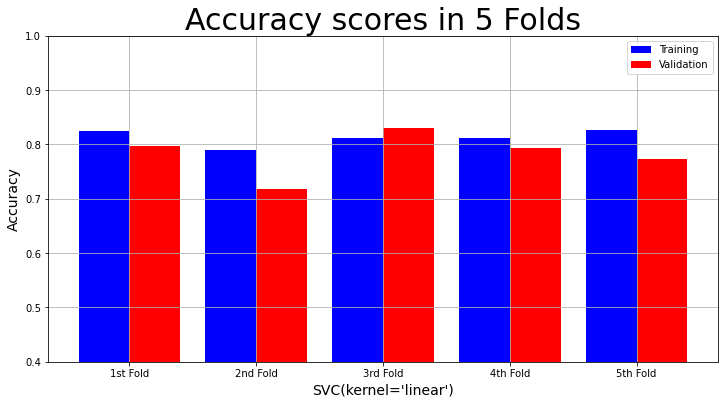

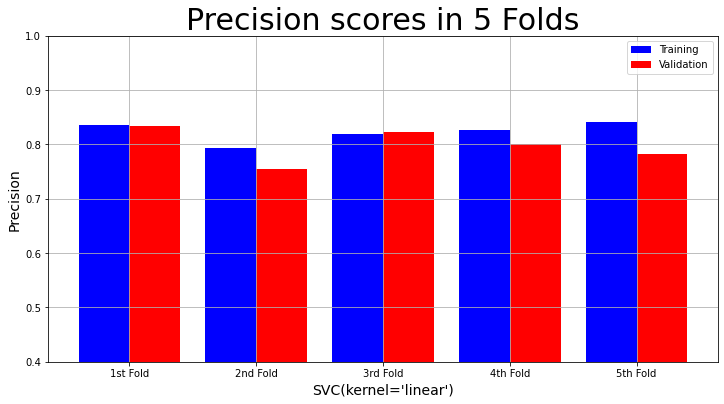

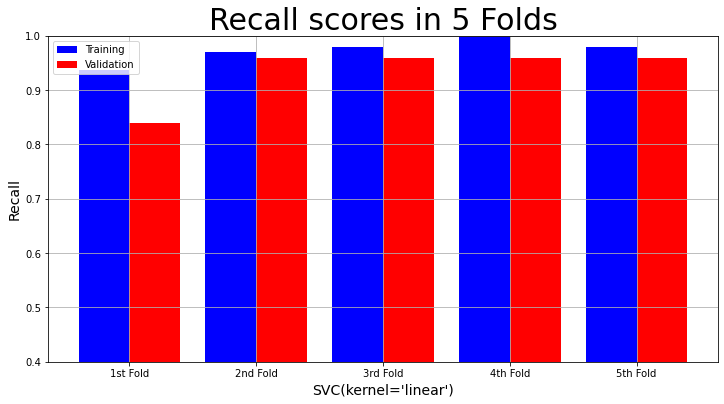

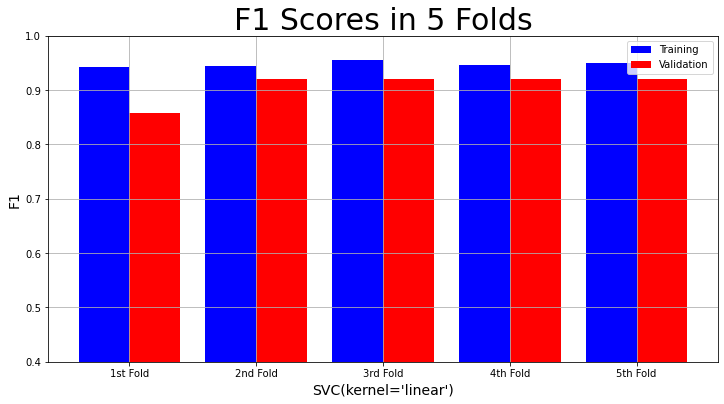

In [247]:
svmclf.fit(X_inter, y_inter)
svm_result = cross_validation(svmclf, X_inter, y_inter, 5)
print(svm_result)
allplot(svmclf,svm_result)

#### with non linear kernel

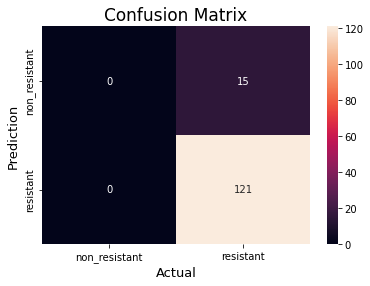

{'Training Accuracy scores': array([0.72641509, 0.71830986, 0.72300469, 0.72769953, 0.73239437]), 'Mean Training Accuracy': 72.55647090087696, 'Training Precision scores': array([0.72380952, 0.71830986, 0.72169811, 0.72511848, 0.72857143]), 'Mean Training Precision': 0.7235014816311504, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([0.83977901, 0.83606557, 0.83835616, 0.84065934, 0.84297521]), 'Mean Training F1 Score': 0.8395670581899652, 'Validation Accuracy scores': array([0.72222222, 0.71698113, 0.71698113, 0.71698113, 0.69811321]), 'Mean Validation Accuracy': 71.42557651991613, 'Validation Precision scores': array([0.72222222, 0.71698113, 0.71698113, 0.71698113, 0.71153846]), 'Mean Validation Precision': 0.7169408159974198, 'Validation Recall scores': array([1.        , 1.        , 1.        , 1.        , 0.97368421]), 'Mean Validation Recall': 0.9947368421052631, 'Validation F1 scores': array([0.83870968, 0.83516484

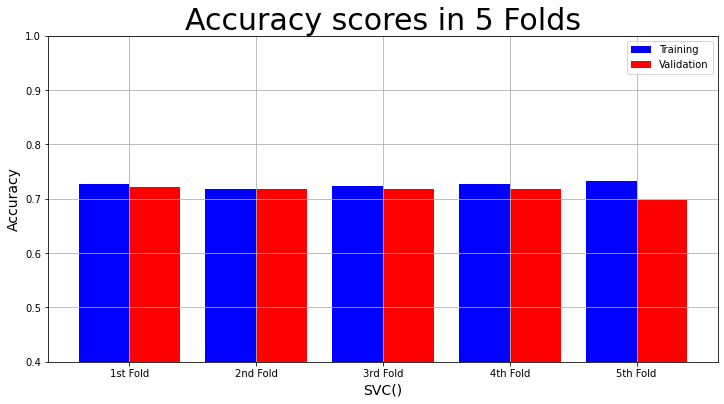

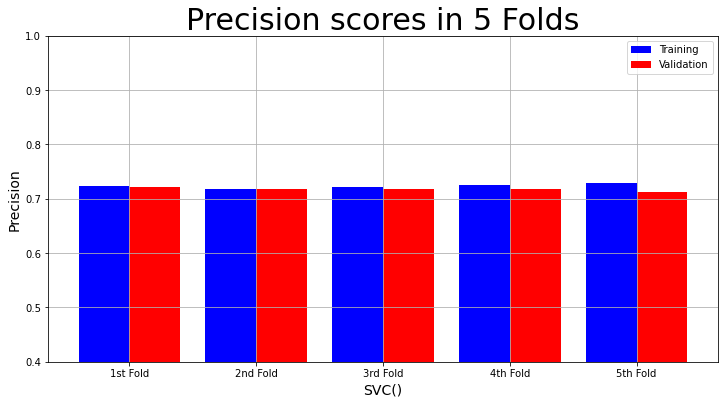

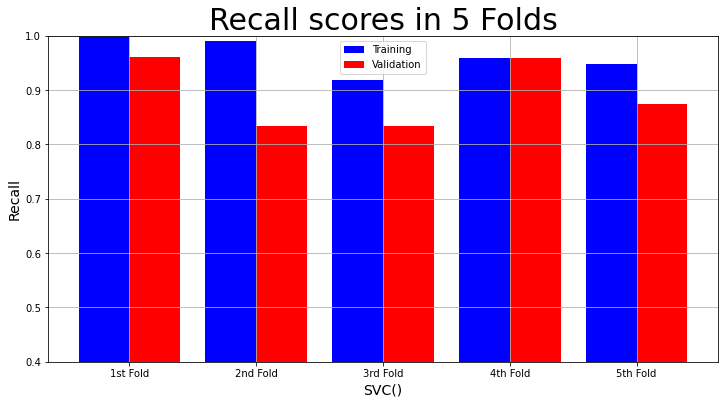

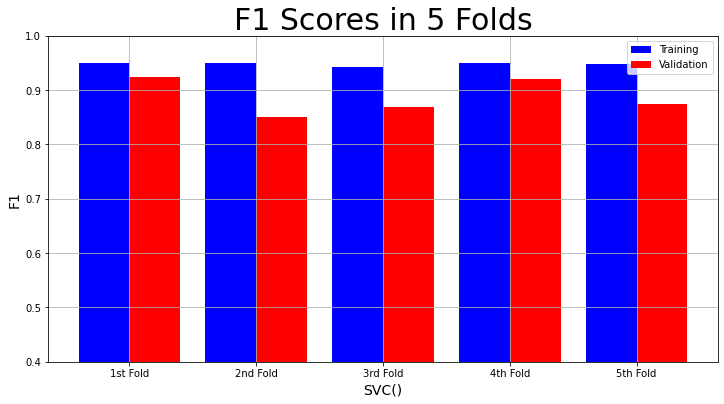

In [206]:
svmclf2.fit(X_inter, y_inter)

svm_result2 = cross_validation(svmclf2, X_inter, y_inter, 5)
print(svm_result2)
allplot(svmclf2,svm_result2)

# small neural network 

### standardization 

In [207]:
from sklearn import preprocessing

X_standard = preprocessing.scale(X)
X_inter_standard =preprocessing.scale(X_inter)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multi

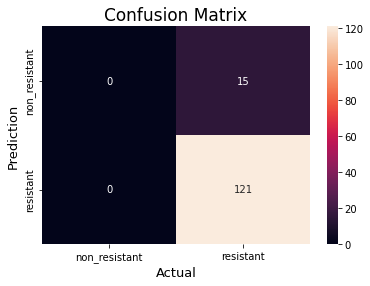

{'Training Accuracy scores': array([0.88888889, 0.88990826, 0.88990826, 0.88990826, 0.88990826]), 'Mean Training Accuracy': 88.97043832823648, 'Training Precision scores': array([0.88888889, 0.88990826, 0.88990826, 0.88990826, 0.88990826]), 'Mean Training Precision': 0.8897043832823648, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([0.94117647, 0.94174757, 0.94174757, 0.94174757, 0.94174757]), 'Mean Training F1 Score': 0.9416333523700743, 'Validation Accuracy scores': array([0.89285714, 0.88888889, 0.88888889, 0.88888889, 0.88888889]), 'Mean Validation Accuracy': 88.96825396825395, 'Validation Precision scores': array([0.89285714, 0.88888889, 0.88888889, 0.88888889, 0.88888889]), 'Mean Validation Precision': 0.8896825396825395, 'Validation Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Validation Recall': 1.0, 'Validation F1 scores': array([0.94339623, 0.94117647, 0.94117647, 0.94117647, 0.94117647]), 'Mean Validatio

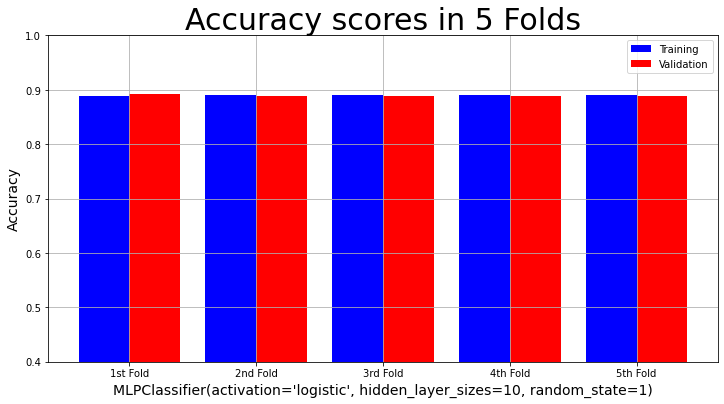

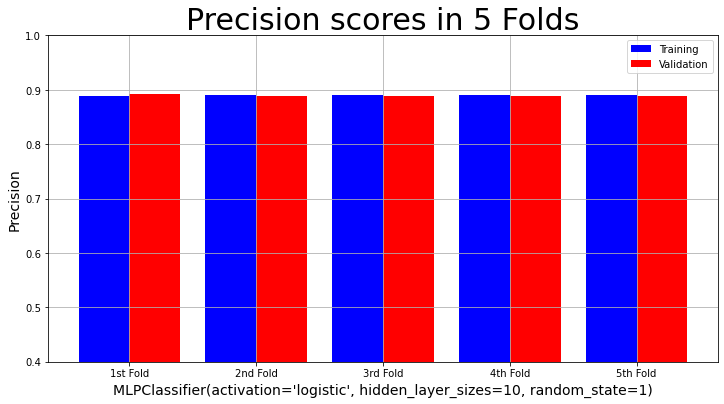

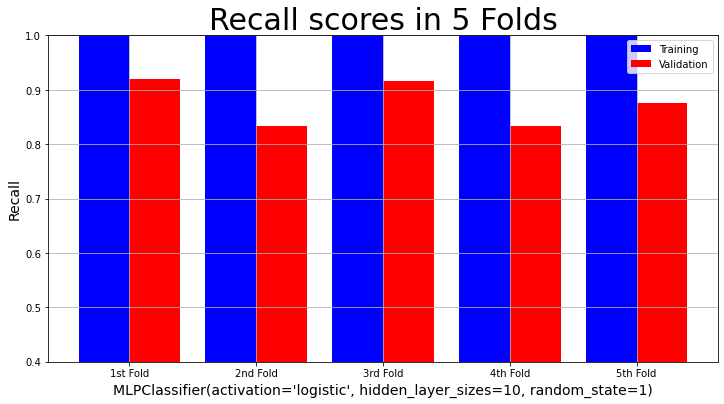

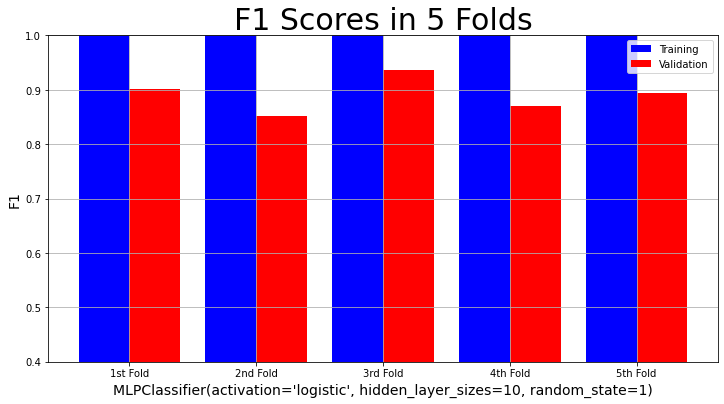

In [79]:
from sklearn.neural_network import MLPClassifier
mlpclf = MLPClassifier(
    hidden_layer_sizes=(10), max_iter=200,
    activation = 'logistic',solver='adam',random_state=1)
mlpclf.fit(X_standard,y)
mlpclf_result = cross_validation(mlpclf, X_standard, y, 5)
print(mlpclf_result)
allplot(mlpclf,mlpclf_result)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


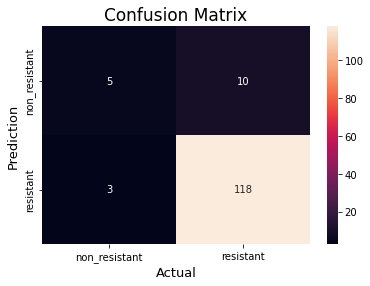

{'Training Accuracy scores': array([1.        , 1.        , 1.        , 1.        , 0.99082569]), 'Mean Training Accuracy': 99.81651376146789, 'Training Precision scores': array([1.        , 1.        , 1.        , 1.        , 0.98979592]), 'Mean Training Precision': 0.9979591836734694, 'Training Recall scores': array([1., 1., 1., 1., 1.]), 'Mean Training Recall': 1.0, 'Training F1 scores': array([1.        , 1.        , 1.        , 1.        , 0.99487179]), 'Mean Training F1 Score': 0.9989743589743589, 'Validation Accuracy scores': array([0.82142857, 0.81481481, 0.85185185, 0.74074074, 0.77777778]), 'Mean Validation Accuracy': 80.13227513227513, 'Validation Precision scores': array([0.88461538, 0.88      , 0.88461538, 0.86956522, 0.875     ]), 'Mean Validation Precision': 0.8787591973244148, 'Validation Recall scores': array([0.92      , 0.91666667, 0.95833333, 0.83333333, 0.875     ]), 'Mean Validation Recall': 0.9006666666666667, 'Validation F1 scores': array([0.90196078, 0.89795918

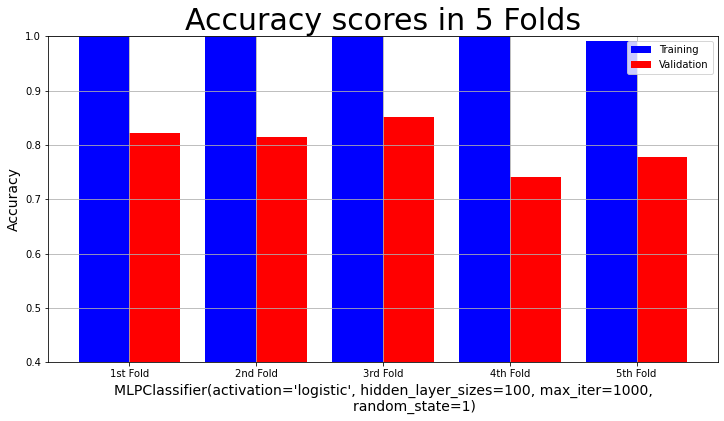

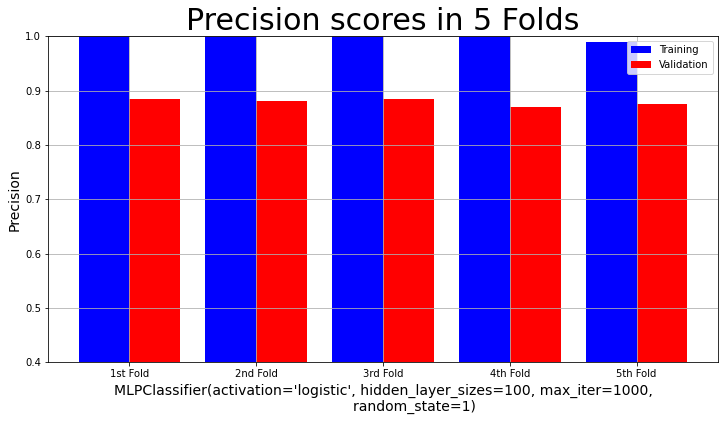

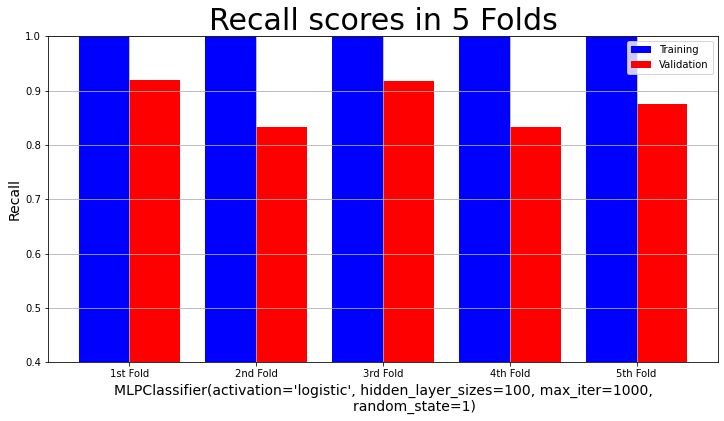

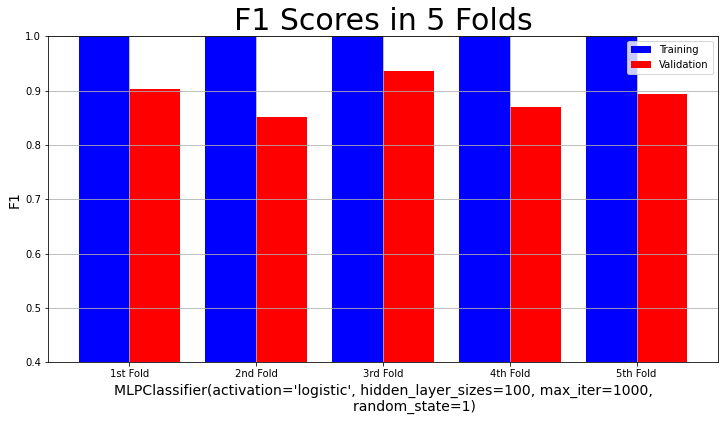

In [76]:
mlpclf2 = MLPClassifier(
    hidden_layer_sizes=(100), max_iter=1000,
    activation = 'logistic',solver='adam',random_state=1)
mlpclf2.fit(X_standard,y)
mlpclf2_result = cross_validation(mlpclf2, X_standard, y, 5)
print(mlpclf2_result)
allplot(mlpclf2,mlpclf2_result)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multi

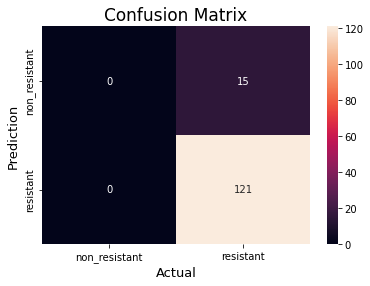

{'Training Accuracy scores': array([0.78301887, 0.78873239, 0.74647887, 0.77464789, 0.75586854]), 'Mean Training Accuracy': 76.9749313491009, 'Training Precision scores': array([0.77604167, 0.78125   , 0.75126904, 0.7638191 , 0.75634518]), 'Mean Training Precision': 0.7657449950684047, 'Training Recall scores': array([0.98026316, 0.98039216, 0.96732026, 0.99346405, 0.97385621]), 'Mean Training Recall': 0.9790591675266598, 'Training F1 scores': array([0.86627907, 0.86956522, 0.84571429, 0.86363636, 0.85142857]), 'Mean Training F1 Score': 0.8593247015875933, 'Validation Accuracy scores': array([0.72222222, 0.69811321, 0.77358491, 0.73584906, 0.73584906]), 'Mean Validation Accuracy': 73.31236897274633, 'Validation Precision scores': array([0.74      , 0.71153846, 0.77083333, 0.74      , 0.75      ]), 'Mean Validation Precision': 0.742474358974359, 'Validation Recall scores': array([0.94871795, 0.97368421, 0.97368421, 0.97368421, 0.94736842]), 'Mean Validation Recall': 0.9634278002699055, 

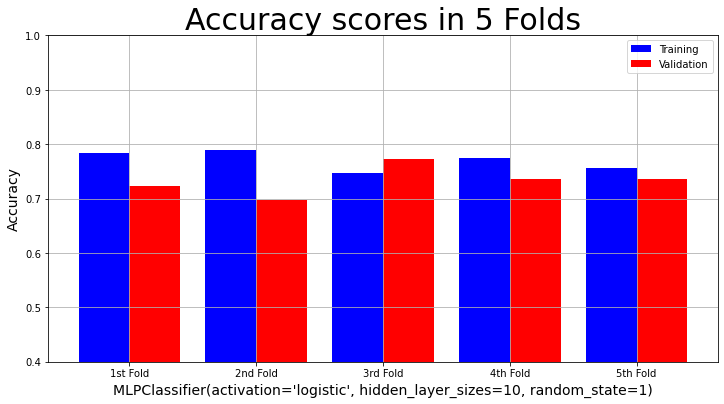

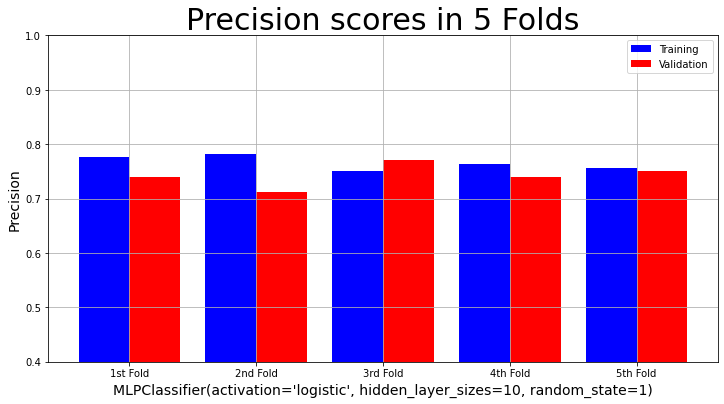

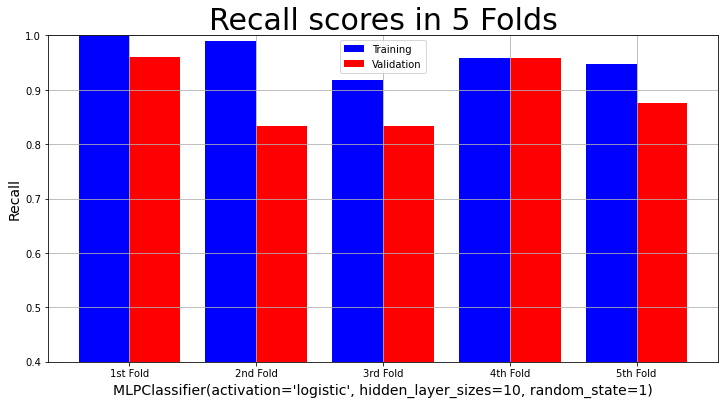

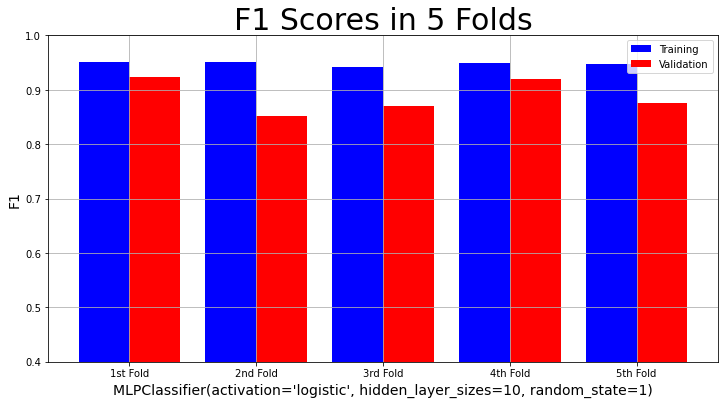

In [208]:
mlpclf.fit(X_inter_standard,y_inter)
mlpclf_result = cross_validation(mlpclf, X_inter_standard, y_inter, 5)
print(mlpclf_result)
allplot(mlpclf,mlpclf_result)

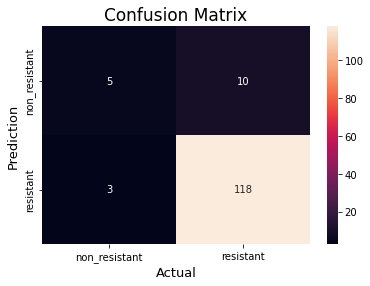

{'Training Accuracy scores': array([0.83018868, 0.83568075, 0.83568075, 0.79342723, 0.81220657]), 'Mean Training Accuracy': 82.14367968819204, 'Training Precision scores': array([0.8372093 , 0.84302326, 0.84302326, 0.8150289 , 0.83431953]), 'Mean Training Precision': 0.8345208484629623, 'Training Recall scores': array([0.94736842, 0.94771242, 0.94771242, 0.92156863, 0.92156863]), 'Mean Training Recall': 0.9371861025111798, 'Training F1 scores': array([0.88888889, 0.89230769, 0.89230769, 0.86503067, 0.8757764 ]), 'Mean Training F1 Score': 0.8828622691732854, 'Validation Accuracy scores': array([0.75925926, 0.60377358, 0.75471698, 0.86792453, 0.67924528]), 'Mean Validation Accuracy': 73.298392732355, 'Validation Precision scores': array([0.7826087 , 0.71794872, 0.76595745, 0.8974359 , 0.74418605]), 'Mean Validation Precision': 0.7816273608713855, 'Validation Recall scores': array([0.92307692, 0.73684211, 0.94736842, 0.92105263, 0.84210526]), 'Mean Validation Recall': 0.8740890688259109, 

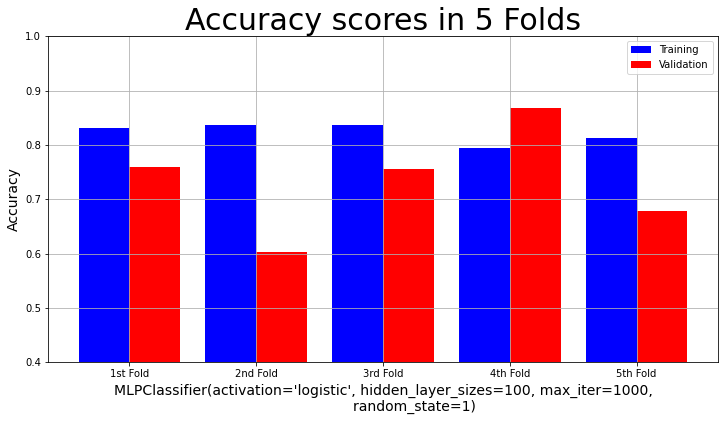

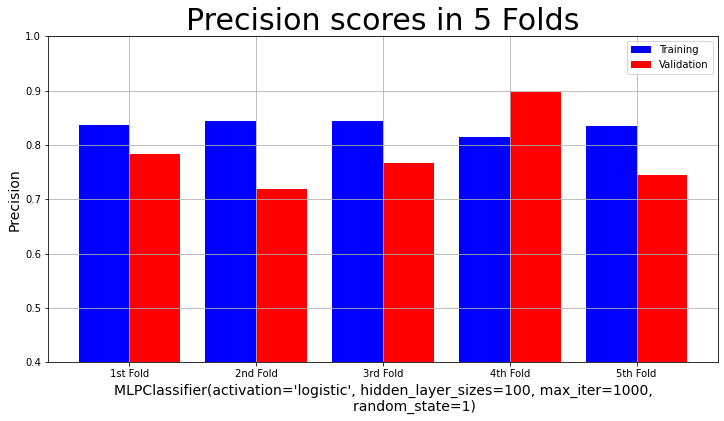

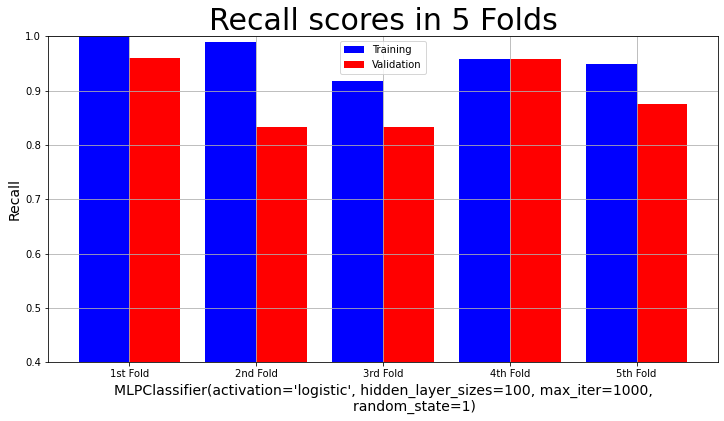

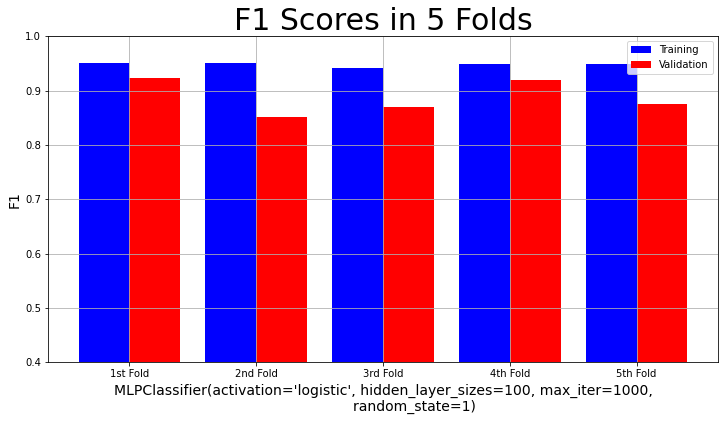

In [209]:
mlpclf2.fit(X_inter_standard,y_inter)
mlpclf2_result = cross_validation(mlpclf2, X_inter_standard, y_inter, 5)
print(mlpclf2_result)
allplot(mlpclf2,mlpclf2_result)